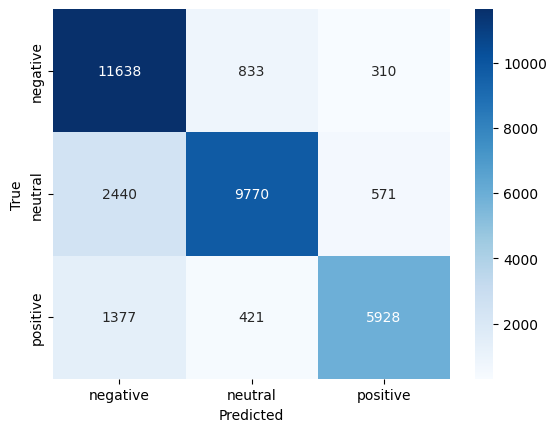


Classification Report:
              precision    recall  f1-score   support

    negative     0.7530    0.9106    0.8243     12781
     neutral     0.8862    0.7644    0.8208     12781
    positive     0.8706    0.7673    0.8157      7726

    accuracy                         0.8212     33288
   macro avg     0.8366    0.8141    0.8203     33288
weighted avg     0.8315    0.8212    0.8210     33288

Macro F1-score: 0.8202866527440644


In [21]:
import re
import string
import pandas as pd
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, f1_score
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils import resample

data = pd.read_csv(r"C:\Users\taras\OneDrive\Desktop\CV_projects\Amazon_reviews_analysis\data\amazon_reviews.csv")
data['content'] = data['content'].fillna("")

def clean_text(text):
    text = text.lower()
    text = re.sub(f"[{re.escape(string.punctuation)}]", " ", text)
    text = re.sub(r"\d+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

data['content'] = data['content'].apply(clean_text)

def categorize_score(score):
    if score <= 2:
        return 'negative'
    elif score == 3:
        return 'neutral'
    else:
        return 'positive'

data['score_cat'] = data['score'].apply(categorize_score)

negative = data[data['score_cat'] == 'negative']
neutral = data[data['score_cat'] == 'neutral']
positive = data[data['score_cat'] == 'positive']

neutral_upsampled = resample(neutral,
                             replace=True,
                             n_samples=max(len(negative), len(positive)),
                             random_state=101)

data_balanced = pd.concat([negative, positive, neutral_upsampled])

train_X, test_X, train_y, test_y = train_test_split(
    data_balanced['content'], data_balanced['score_cat'],
    test_size=0.3,
    random_state=101,
    stratify=data_balanced['score_cat']
)

pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5, ngram_range=(1,2))),
    ('nb', MultinomialNB(alpha=0.1)),
])

pipeline.fit(train_X, train_y)
predictions = pipeline.predict(test_X)

cm = confusion_matrix(test_y, predictions, labels=['negative','neutral','positive'])
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['negative','neutral','positive'], yticklabels=['negative','neutral','positive'])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print("\nClassification Report:")
print(classification_report(test_y, predictions, digits=4))
print("Macro F1-score:", f1_score(test_y, predictions, average='macro'))
